#### Package Requirements
```
pip install coiled "dask[complete]"
pip install earthaccess xarray matplotlib scipy h5netcdf
```

In [1]:
## Version numbers listed next to each package:

# Data location and access packages:
import earthaccess                                 # 0.6.1

# Analysis packages:
import xarray as xr                                # 2023.9.0
import numpy as np                                 # 1.26.0

# Visualization packages:
import matplotlib.pyplot as plt                    # 3.8.0

# Cloud computing / dask packages:
import coiled

%matplotlib inline

In [2]:
xr.set_options( # display options for xarray objects
    display_expand_attrs=False,
    display_expand_coords=True,
    display_expand_data=True,
)

# Earthdata Login and locate MUR file access endpoints

In [3]:
earthaccess.login() # Login with your credentials

Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


In [4]:
## Access info for entire record:
datainfo = earthaccess.search_data(
    short_name="MUR-JPL-L4-GLOB-v4.1",
    cloud_hosted=True,
    #temporal=("2002-01-01", "2013-05-01"),
    )

Granules found: 7918


In [5]:
datainfo[0]

Collection: {'Version': '4.1', 'ShortName': 'MUR-JPL-L4-GLOB-v4.1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180, 'SouthBoundingCoordinate': -90, 'EastBoundingCoordinate': 180, 'NorthBoundingCoordinate': 90}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2002-06-01T21:00:00.000Z', 'BeginningDateTime': '2002-05-31T21:00:00.000Z'}}
Size(MB): 332.3598403930664
Data: ['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc']

In [6]:
## Thin out data files to get weekly temporal resolution for this demo:
datainfo_thinned = [datainfo[i] for i in range(len(datainfo)) if i%3==0]
#datainfo_thinned = datainfo_thinned[int(len(datainfo)/2):]

#datainfo_thinned = datainfo[:6260]
#datainfo_thinned = [datainfo_thinned[i] for i in range(len(datainfo_thinned)) if i%7==0]

In [7]:
## Confirm we have full record and at 3-day resolution:
print("Total number of files \n--------------------------")
print(len(datainfo_thinned))
print("\nFirst and last file times \n--------------------------")
print(datainfo_thinned[0]['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'])
print(datainfo_thinned[-1]['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'])
print("\nFirst and second file times \n--------------------------")
print(datainfo_thinned[0]['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'])
print(datainfo_thinned[1]['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'])

Total number of files 
--------------------------
2640

First and last file times 
--------------------------
2002-05-31T21:00:00.000Z
2024-02-05T21:00:00.000Z

First and second file times 
--------------------------
2002-05-31T21:00:00.000Z
2002-06-03T21:00:00.000Z


# Inspect a file

In [8]:
## Open a file:
fileobj_test = earthaccess.open([datainfo_thinned[0]])[0] # Generate file objects from the endpoints which are compatible with Xarray
mur_test = xr.open_dataset(fileobj_test)
sst_test = mur_test['analysed_sst']

Opening 1 granules, approx size: 0.32 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
## Define some geolocations for the analysis:

# Region to perform analysis over:
lat_region = (30, 45)
lon_region = (-135, -105)

# Points to plot seasonal cycle at:
lat_points = (38, 38, 38, 38)
lon_points = (-123.25, -125, -128, -132)

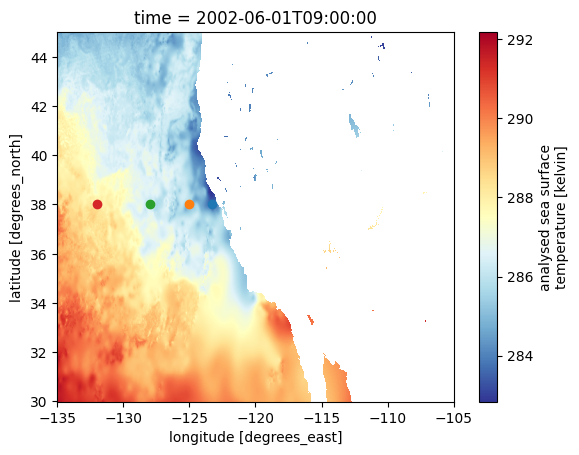

In [10]:
## Plot SST in analysis region and mark 4 points for seasonal cycle:
fig = plt.figure()
sst_test.sel(lat=slice(*lat_region), lon=slice(*lon_region)).plot(cmap='RdYlBu_r')

for lat, lon in zip(lat_points, lon_points):
    plt.scatter(lon, lat)

# Compute mean seasonal cycle for a decade of data at weekly temporal resolution

In [11]:
cluster = coiled.Cluster(
    n_workers=25, 
    account="podaac-science", 
    region="us-west-2", 
    worker_vm_types="c7g.xlarge", 
    scheduler_vm_types="c7g.large",
    name='podaac-science-c19b66e1'
    ) 
client = cluster.get_client()

Output()

╭────────────────────────────────────────── Package Info ──────────────────────────────────────────╮
│                             ╷                                                                    │
│   Package                   │ Note                                                               │
│ ╶───────────────────────────┼──────────────────────────────────────────────────────────────────╴ │
│   Babel                     │ https://pypi.org/pypi                                              │
│   Cartopy                   │ https://pypi.org/pypi                                              │
│   Deprecated                │ https://pypi.org/pypi                                              │
│   Jinja2                    │ https://pypi.org/pypi                                              │
│   MarkupSafe                │ https://pypi.org/pypi                                              │
│   Pillow                    │ https://pypi.org/pypi                                              │
│   PyNaCl                    │ https://pypi.org/pypi                                              │
│   PyYAML                    │ https://pypi.org/pypi                                              │
│   Pygments                  │ https://pypi.org/pypi                                              │
│   Send2Trash                │ https://pypi.org/pypi                                              │
│   aiobotocore               │ https://pypi.org/pypi                                              │
│   aiohttp                   │ https://pypi.org/pypi                                              │
│   aioitertools              │ https://pypi.org/pypi                                              │
│   aiosignal                 │ https://pypi.org/pypi                                              │
│   anyio                     │ https://pypi.org/pypi                                              │
│   argon2-cffi               │ https://pypi.org/pypi                                              │
│   argon2-cffi-bindings      │ https://pypi.org/pypi                                              │
│   arrow                     │ https://pypi.org/pypi                                              │
│   asttokens                 │ https://pypi.org/pypi                                              │
│   async-lru                 │ https://pypi.org/pypi                                              │
│   async-timeout             │ https://pypi.org/pypi                                              │
│   attrs                     │ https://pypi.org/pypi                                              │
│   backcall                  │ https://pypi.org/pypi                                              │
│   backoff                   │ https://pypi.org/pypi                                              │
│   bcrypt                    │ https://pypi.org/pypi                                              │
│   beautifulsoup4            │ https://pypi.org/pypi                                              │
│   bleach                    │ https://pypi.org/pypi                                              │
│   bokeh                     │ https://pypi.org/pypi                                              │
│   boto3                     │ https://pypi.org/pypi                                              │
│   botocore                  │ https://pypi.org/pypi                                              │
│   bounded-pool-executor     │ https://pypi.org/pypi                                              │
│   certifi                   │ https://pypi.org/pypi                                              │
│   cffi                      │ https://pypi.org/pypi                                              │
│   cftime                    │ https://pypi.org/pypi                                              │
│   charset-normalizer        │ https://pypi.org/pypi                                              │
│   click                     │ https://pypi.org/pypi        

Output()

In [13]:
fileobjs = earthaccess.open(datainfo_thinned) # Generate file objects from the endpoints which are compatible with Xarray

Opening 2640 granules, approx size: 1092.93 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/2640 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2640 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2640 [00:00<?, ?it/s]

In [24]:
#import dask
#dask.config.set(**{'array.slicing.split_large_chunks': False})

In [24]:
#datainfo_thinned[606]

Collection: {'Version': '4.1', 'ShortName': 'MUR-JPL-L4-GLOB-v4.1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180, 'SouthBoundingCoordinate': -90, 'EastBoundingCoordinate': 180, 'NorthBoundingCoordinate': 90}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2014-01-11T21:00:00.000Z', 'BeginningDateTime': '2014-01-10T21:00:00.000Z'}}
Size(MB): 339.5150899887085
Data: ['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20140111090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc']

In [12]:
#test = xr.open_dataset(fileobjs[606])
#test.analysed_sst.plot()

In [25]:
#fileobjs_test = fileobjs[1000:1400] + fileobjs[1420:1500]
#len(fileobjs_test)

480

In [37]:
## Current stats with 3 day thinning of entire record:
## * index 0-500 good
## * index 500-1000 good
## * index 1000-1500 bad 
##     * index 1000-1410 good
##     * index 1410-1420 bad 
##     * index 1420-1500 good
## * index 1500-2000 bad
##     * index 1500-1530 good
##     * index 1530-1540 bad
##     * index 1540-1560 good
##     * index 1560-1570 bad
##     * index 1560-1570 bad
##     * index 1570-1650 good
##     * index 1650-1660 bad
##     * index 1660-1700 good
##     * index 1700-1720 bad


##     * index 1700-1800 bad <-- Need more detailed look
##     * index 1800-1850 good
##     * index 1850-1860 bad 
##     * index 1860-1900 good
##     * index 1900-1910 bad
##     * index 1910-2000 good

## * index 2000-2500 bad

datainfo_test = (
    datainfo_thinned[0:1410] 
    + datainfo_thinned[1420:1530]
    #+ datainfo_thinned[1540:1560]
    + datainfo_thinned[1570:1650] 
    + datainfo_thinned[1660:1700] 
    #+ datainfo_thinned[1660:1700]
    #+ datainfo_thinned[1800:1850]
    #+ datainfo_thinned[1860:1900]
    #+ datainfo_thinned[1910:2000]
    )

In [38]:
fileobjs_test = earthaccess.open(datainfo_test)

Opening 1640 granules, approx size: 544.62 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1640 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1640 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1640 [00:00<?, ?it/s]

In [35]:
%%time

## Load files and rechunk SST data:
#murdata = xr.open_mfdataset(fileobjs[600:650], parallel=True, chunks={'lat': 6000, 'lon': 6000, 'time': 1})
#murdata = xr.open_mfdataset(fileobjs[607:650], parallel=True, chunks={'lat': 3000, 'lon': 3000, 'time': 1})
#murdata = xr.open_mfdataset(fileobjs[1710:1720], parallel=True, chunks={'lat': 3000, 'lon': 3000, 'time': 1},) #drop_variables=['analysis_error','mask','sea_ice_fraction'])
murdata = xr.open_mfdataset(fileobjs_test, parallel=True, chunks={'lat': 3000, 'lon': 3000, 'time': 1})

sst = murdata["analysed_sst"]
#sst = sst.chunk(chunks={'lat': 500, 'lon': 500, 'time': 200})
#sst = sst.chunk(chunks={'lat': 300, 'lon': 500, 'time': 400})
sst

CPU times: user 14.7 s, sys: 959 ms, total: 15.7 s
Wall time: 1min 46s


<xarray.DataArray 'analysed_sst' (time: 1600, lat: 17999, lon: 36000)>
dask.array<concatenate, shape=(1600, 17999, 36000), dtype=float32, chunksize=(1, 3000, 3000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2002-06-01T09:00:00 ... 2015-12-17T09:00:00
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes: (7)

In [40]:
## ----------------
## Set up analysis
## ----------------
## (Since we're dealing with dask arrays, these functions calls don't do the computations yet, just set them up)

## Subset to region off U.S.A. west coast:
sst_regional = sst.sel(lat=slice(*lat_region), lon=slice(*lon_region))

## Remove linear warming trend:
p = sst_regional.polyfit(dim='time', deg=1) # Degree 1 polynomial fit coefficients over time for each lat, lon.
fit = xr.polyval(sst_regional['time'], p.polyfit_coefficients) # Compute linear trend time series at each lat, lon.
sst_detrend = (sst_regional - fit) # xarray is smart enough to subtract along the time dim only.

## Mean seasonal cycle:
seasonal_cycle = sst_detrend.groupby("time.month").mean("time")

In [41]:
%%time
## ----------------
## Compute it all!!
## ----------------
seasonal_cycle = seasonal_cycle.compute()
cluster.scale(1)

/opt/coiled/env/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 90.80 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


MemoryError: Task ('rechunk-merge-4659094536b3e194637202ce2f0c753b', 0, 2) has 13.42 GiB worth of input dependencies, but worker tls://10.0.0.12:37531 has memory_limit set to 7.19 GiB.

In [35]:
client.shutdown()
cluster.shutdown()

# Plot results

Text(0, 0.5, '$\\Delta$T (K)')

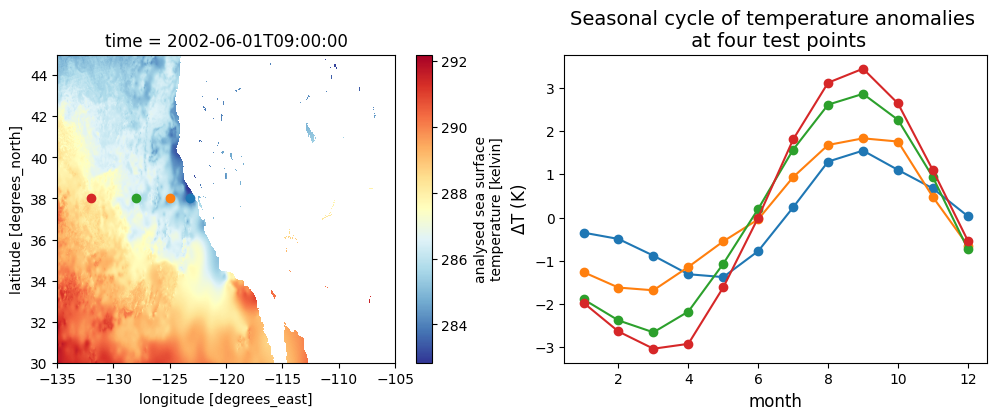

In [56]:
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 4))

## Replot the map and points from the test file:
sst_test.sel(lat=slice(*lat_region), lon=slice(*lon_region)).plot(ax=axes2[0], cmap='RdYlBu_r')
for lat, lon in zip(lat_points, lon_points):
    axes2[0].scatter(lon, lat)

## Seasonal cycles on another plot
for lat, lon in zip(lat_points, lon_points):
    scycle_point = seasonal_cycle.sel(lat=lat, lon=lon)
    axes2[1].plot(scycle_point['month'], scycle_point.values, 'o-')

axes2[1].set_title("Seasonal cycle of temperature anomalies \n at four test points", fontsize=14)
axes2[1].set_xlabel("month", fontsize=12)
axes2[1].set_ylabel(r"$\Delta$T (K)", fontsize=12)